In [65]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from pysal.lib import weights
from pysal.explore import esda
import matplotlib.pyplot as plt
import seaborn as sns
import contextily
from pysal.model import spreg
import statsmodels.formula.api as smf
import contextily as ctx
from libpysal.weights import KNN
from spreg import OLS
from libpysal.weights import lag_spatial
from spreg import GM_Lag
from libpysal.weights import Kernel
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# OLS Spacial Regression

--> Embed location through the model

## Load data

In [200]:
well_filter = 1

current_dir = os.getcwd()
path = os.path.join(current_dir, '../../data/clean/aligned_data', f"merged_dataset_{well_filter}.csv")
df = pd.read_csv(path)
len(df)

192

## Sort by date

In [201]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

## Remove outlier based on "Soil region"

In [155]:
# df = df[df["soil region"] != "veen"].copy()

In [202]:
print(df["soil region"].value_counts())

soil region
zand    132
klei     43
veen     17
Name: count, dtype: int64


## Remove columns

In [203]:
df = df.drop(columns=['landuse code', 'soil region'])
print(df.columns)
df = df.dropna()
len(df)

Index(['bro-id', 'nitrate', 'geometry', 'date', 'population',
       'groundwater depth', 'elevation', 'lon', 'lat', 'precipitation',
       'temperature', 'n deposition', 'soilunit_code_1',
       'organicmattercontent_1', 'density_1', 'acidity_1'],
      dtype='object')


132

## Add month and year as features

In [204]:
# df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

## Log transform

In [205]:
df["nitrate"] = np.log1p(df["nitrate"])

## Change column type

In [206]:
# convert to categorical
predefined_categories = {
    "soil region": None,
    "landuse code": None,
    "soilunit_code_1": None 
}


for col, fixed_categories in predefined_categories.items():
    if col in df.columns:
        categories = sorted(df[col].dropna().unique().tolist())
        
        df[col] = pd.Categorical(df[col], categories=categories)

In [167]:
df.dtypes

bro-id                                 object
nitrate                               float64
geometry                               object
date                      datetime64[ns, UTC]
population                            float64
groundwater depth                     float64
elevation                             float64
lon                                   float64
lat                                   float64
precipitation                         float64
temperature                           float64
n deposition                          float64
soilunit_code_1                      category
organicmattercontent_1                float64
density_1                             float64
acidity_1                             float64
year                                    int32
dtype: object

## Remove spatial outlier

In [162]:
# GMW000000024093

# target_well = ['GAR000000000307', 'GAR000000000308', 'GAR000000000309']
# df = df.drop(df[df["bro-id"].isin(target_well)].index)
# len(df)

129

## Remove nitrate outliers

In [2201]:
# q1 = df["Nitrate"].quantile(0.25)
# q3 = df["Nitrate"].quantile(0.75)
# iqr = q3 - q1

# lower_bound = q1 - 1.5 * iqr
# upper_bound = q3 + 1.5 * iqr

# outliers = df[(df["Nitrate"] < lower_bound) | (df["Nitrate"] > upper_bound)]
# print(f"Outliers found: {len(outliers)}")
# outliers

# top_nitrate_outliers = list(df["Nitrate"].sort_values()[-len(outliers):].index)
# top_nitrate_outliers
# df = df.drop(top_nitrate_outliers)
# len(df)

## One hot encode

In [207]:
df = df.drop(columns=['bro-id', 'lon', 'lat'])

In [208]:
categorical_cols = df.select_dtypes(include="category").columns.tolist()
numerical_cols = df.select_dtypes(include=["float64", "int64", "int32"]).columns.tolist()

In [209]:
print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)
print("All X_train columns:", df.columns.tolist())

Categorical: ['soilunit_code_1']
Numerical: ['nitrate', 'population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'organicmattercontent_1', 'density_1', 'acidity_1', 'year']
All X_train columns: ['nitrate', 'geometry', 'date', 'population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'soilunit_code_1', 'organicmattercontent_1', 'density_1', 'acidity_1', 'year']


In [210]:
df_cat = pd.get_dummies(df[categorical_cols], drop_first=True)
df_num = df[numerical_cols]

df_all = pd.concat([df_num, df_cat], axis=1)
df_all = df_all.astype(float)

--> Remove columns without any variation (one value for entire column)

In [ ]:
# X_check = df_all.copy()
# X_check["soil region"] = df["soil region"]
# grouped_uniques = X_check.groupby("soil region").nunique()
# drop_cols = grouped_uniques.columns[grouped_uniques.min() <= 1]
# df_all = df_all.drop(columns=drop_cols).copy()

## Test / train split

In [193]:
df_all = df_all.drop(columns=['soilunit_code_1_zVp', 'soilunit_code_1_zEZ21'])

In [211]:
train_df = df_all[df_all["year"].isin([2012, 2013, 2014, 2015, 2016, 2017])]
train_df = train_df.loc[:, train_df.nunique() > 1].copy()

test_df  = df_all[df_all["year"].isin([2018, 2019, 2020])]

# update list of num variables
numerical_cols.remove("nitrate")
numerical_cols.remove("year")

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

X_train = train_df.drop(columns=["nitrate", "year"]).copy()
X_train_cat = X_train.drop(columns=numerical_cols)
X_train_num = X_train[numerical_cols]
y_train = train_df["nitrate"]

X_test = test_df.drop(columns=["nitrate", "year"]).copy()
X_test_cat = X_test.drop(columns=numerical_cols)
X_test_num = X_test[numerical_cols]
y_test = test_df["nitrate"]

Train: 84
Test: 48


In [212]:
train_df.shape

(84, 29)

## Normalize

In [213]:
scaler = StandardScaler()

# scale train
X_train_num_scaled = scaler.fit_transform(X_train_num)

X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)
X_train_df = pd.concat([X_train_num_scaled, X_train_cat], axis=1)
X_train_df['const'] = 1.0
feature_names = X_train_num_scaled.columns.tolist() + X_train_cat.columns.tolist()
X_train = X_train_df[feature_names].values


# scale test
X_test_num_scaled = scaler.transform(X_test_num)

X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)
X_test_df = pd.concat([X_test_num_scaled, X_test_cat], axis=1)
X_test_df['const'] = 1.0
X_test = X_test_df[feature_names].values

## Simple OLS regression

--> Groundwater depth: 0.0005

--> Acidity_1: 0.00013

--> soilunit_code_1_zEZ21 : 0.001

In [ ]:
ols_model = spreg.OLS(y_train, X_train, name_y='nitrate', name_x=feature_names)
print(ols_model.summary)

In [177]:
import numpy as np

# Suppose X_clean is the 2D numpy array you are actually feeding to OLS now
XtX = X_train.T.dot(X_train)
rank_XtX = np.linalg.matrix_rank(XtX)
full_cols = XtX.shape[0]
print(f"Rank(X'X) = {rank_XtX} / {full_cols}")

Rank(X'X) = 25 / 25


In [117]:
import numpy as np

def find_dependent_columns(X, tol=1e-10):
    """
    Returns the indices of linearly dependent columns in X
    using SVD-based rank estimation.
    """
    # Full SVD
    U, s, Vt = np.linalg.svd(X, full_matrices=False)

    # Rank estimate: number of singular values above threshold
    rank = (s > tol).sum()
    
    # If full rank, return empty list
    if rank == X.shape[1]:
        return []

    # Otherwise, find dependent columns via reduced row echelon form
    from sympy import Matrix
    rref_matrix, pivot_cols = Matrix(X).T.rref()
    all_cols = set(range(X.shape[1]))
    dependent_cols = sorted(all_cols - set(pivot_cols))
    return dependent_cols

deps = find_dependent_columns(X_train)
print("Dependent column indices:", deps)

Dependent column indices: [27]


In [118]:
print("Dependent column 25:")
print(X_train[:, 25])

print("\nDependent column 26:")
print(X_train[:, 26])

Dependent column 25:
[ 1.86508232e-01  9.65923955e-01  7.22084399e-01  1.27507768e+00
 -1.49859727e+00  1.05736379e+00 -5.45010436e-01 -3.01170880e-01
 -2.18439602e-01 -4.14382102e-01 -8.67226992e-01  1.44054023e+00
 -3.36005102e-01 -6.05970325e-01 -1.43763738e+00  1.39264318e+00
  2.46814979e+00 -1.66188269e-01 -4.27444936e-01 -7.01764436e-01
  1.06607234e+00  1.77581962e+00  8.63598427e-02 -2.61982380e-01
 -1.11542083e+00  1.53198007e+00  1.40135173e+00 -6.05970325e-01
 -2.61982380e-01  1.47972873e+00  1.05736379e+00 -2.61982380e-01
  2.02401346e+00  5.34850454e-01 -7.25712964e-04 -1.03704383e+00
 -8.75935547e-01 -1.44199166e+00  1.82153954e-01  1.51456296e+00
 -5.18884769e-01 -4.27444936e-01  1.89338512e+00 -1.96450499e+00
  6.65478788e-01  1.50585440e+00  3.60679343e-01 -8.54164159e-01
 -1.02833527e+00  9.61569677e-01  8.44004177e-01  3.25845121e-01
 -8.80289825e-01  2.86656621e-01 -8.14975658e-01  8.44004177e-01
 -5.49364714e-01 -5.53718991e-01 -1.25040344e+00  6.39353121e-01
 -9.

In [101]:
print("Column name for 25:", feature_names[25])
print("Column name for 26:", feature_names[26])

Column name for 25: soilunit_code_1_zEZ21
Column name for 26: soilunit_code_1_zVp


In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif["feature"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif.sort_values("VIF", ascending=False))

                   feature        VIF
13   soilunit_code_1_Rn47C        inf
14   soilunit_code_1_Rn67C        inf
25   soilunit_code_1_zEZ21        inf
24     soilunit_code_1_vWz        inf
23   soilunit_code_1_pZn21        inf
22   soilunit_code_1_pZg23        inf
21   soilunit_code_1_pZg21        inf
20   soilunit_code_1_cHn21        inf
19  soilunit_code_1_bRn46C        inf
18   soilunit_code_1_bEZ30        inf
17    soilunit_code_1_Zd21        inf
16     soilunit_code_1_Y30        inf
15   soilunit_code_1_Rn95A        inf
26     soilunit_code_1_zVp        inf
12   soilunit_code_1_Rn44C        inf
11   soilunit_code_1_Rd90C        inf
10   soilunit_code_1_Mv41C        inf
9     soilunit_code_1_Hd21        inf
8                acidity_1        inf
7                density_1        inf
6   organicmattercontent_1        inf
0               population  15.483638
5             n deposition   8.056391
1        groundwater depth   3.893262
2                elevation   1.920000
4           

## Outlier clusters

In [269]:
knn = weights.KNN.from_dataframe(df, k=4)

/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  warnings.warn(message)


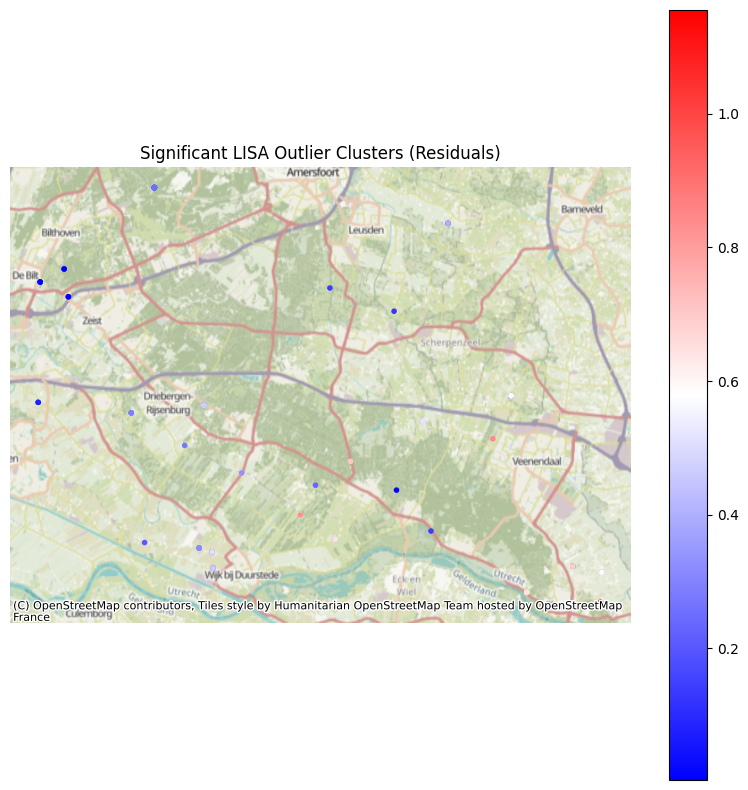

<Figure size 640x480 with 0 Axes>

In [270]:
knn.reweight(k=15, inplace=True)
knn.transform = "R"
outliers = esda.moran.Moran_Local(ols_model.u, knn, permutations=9999)
error_clusters = outliers.q % 2 == 1

#---------------------------

error_df = df.assign(
    error_clusters=error_clusters,
    local_I=outliers.Is
).query("error_clusters").sort_values("local_I")

fig, ax = plt.subplots(figsize=(10, 10))
error_df.plot("local_I", cmap="bwr", marker=".", ax=ax, legend=True)
contextily.add_basemap(ax, crs=df.crs)
ax.set_axis_off()
plt.title("Significant LISA Outlier Clusters (Residuals)")
plt.show()

#---------------------------

contextily.add_basemap(ax, crs=df.crs)
ax.set_axis_off()

## Spatial fixed effects

--> We influence constant term

--> Instead of assuming the dependent variable behaves uniformly over space, there are systematic effects following a geographical pattern

--> Constant term to vary geographically

--> **Other** elements of the regression are left untouched and hence apply **uniformly** across space

--> Each region gets its own intercept

--> Control for spatial heterogeneity

In [314]:
predictors = ['population',
'groundwater depth',
'elevation',
'precipitation',
'temperature',
'n deposition',
'organicmattercontent_1',
'density_1',
'acidity_1',
'month']

# formula = "log_nitrate ~ " + " + ".join(predictors) + " + C(soil region) - 1"
formula = "log_nitrate ~ " + " + ".join([f"Q('{col}')" for col in predictors]) + " + C(Q('soilunit_code_1'))" + " + C(Q('soil region')) - 1"

In [315]:
model = smf.ols(formula, data=df).fit()

In [316]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            log_nitrate   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     23.17
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           8.84e-30
Time:                        18:06:03   Log-Likelihood:                -42.830
No. Observations:                 118   AIC:                             141.7
Df Residuals:                      90   BIC:                             219.2
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
C(Q('soilu

#### Wells on **zand** soils have significantly **higher nitrate** concentrations, even when controlling for depth, population, temperature

In [317]:
print(model.params.index)

Index(['C(Q('soilunit_code_1'))[EZg21]', 'C(Q('soilunit_code_1'))[Hd21]',
       'C(Q('soilunit_code_1'))[Hd30]', 'C(Q('soilunit_code_1'))[Hn21]',
       'C(Q('soilunit_code_1'))[Rd90C]', 'C(Q('soilunit_code_1'))[Rn44C]',
       'C(Q('soilunit_code_1'))[Rn47C]', 'C(Q('soilunit_code_1'))[Rn67C]',
       'C(Q('soilunit_code_1'))[Rn95A]', 'C(Q('soilunit_code_1'))[Y21]',
       'C(Q('soilunit_code_1'))[Y30]', 'C(Q('soilunit_code_1'))[Zd21]',
       'C(Q('soilunit_code_1'))[bEZ30]', 'C(Q('soilunit_code_1'))[bRn46C]',
       'C(Q('soilunit_code_1'))[cHn21]', 'C(Q('soilunit_code_1'))[pZg21]',
       'C(Q('soilunit_code_1'))[pZg23]', 'C(Q('soilunit_code_1'))[pZn21]',
       'C(Q('soilunit_code_1'))[vWz]', 'C(Q('soilunit_code_1'))[zEZ21]',
       'C(Q('soil region'))[T.klei]', 'Q('population')',
       'Q('groundwater depth')', 'Q('elevation')', 'Q('precipitation')',
       'Q('temperature')', 'Q('n deposition')', 'Q('organicmattercontent_1')',
       'Q('density_1')', 'Q('acidity_1')', 'Q('mon

--> The log nitrate concentration is, on average, 0.7 units lower in klei (clay) regions

In [330]:
sfe_names = [i for i in model.params.index if "C(Q('soil region'))" in i]

soil_fixed_effects = pd.DataFrame({
    "Coef.": model.params[sfe_names],
    "Std. Error": model.bse[sfe_names],
    "P-Value": model.pvalues[sfe_names],
})

# soil_fixed_effects.index = [name.split("[T.")[1].strip("]") for name in sfe_names]
# soil_fixed_effects.index.name = "soil region"
# soil_fixed_effects.reset_index(inplace=True)

soil_fixed_effects = model.params.filter(like="C(Q('soil region'))")
soil_fixed_effects.index = soil_fixed_effects.index.str.extract(r"C\(Q\('soil region'\)\)\[T\.(.*)\]")[0]
soil_fixed_effects.name = "fixed_effect"
soil_fixed_effects = soil_fixed_effects.reset_index().rename(columns={0: "soil_region"})

soil_fixed_effects = pd.DataFrame({
    "soil_region": [name.split("[T.")[1].strip("]") for name in sfe_names],
    "Coef.": model.params[sfe_names],
    "Std. Error": model.bse[sfe_names],
    "P-Value": model.pvalues[sfe_names],
})


soil_fixed_effects

,soil_region,Coef.,Std. Error,P-Value
C(Q('soil region'))[T.klei],klei,-0.70143,0.210781,0.001269


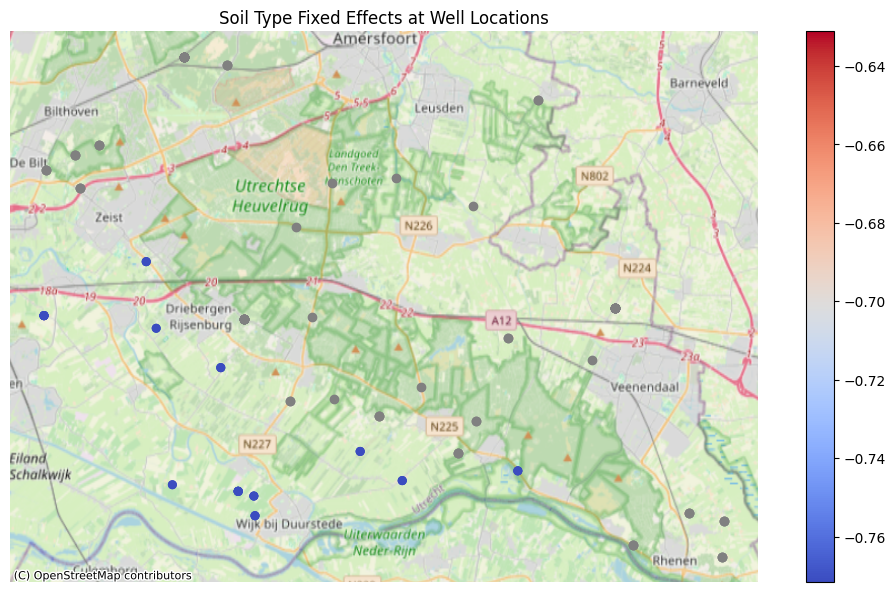

In [335]:
wells = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

soil_fixed_effects = model.params.filter(like="C(Q('soil region'))")
soil_fixed_effects.index = soil_fixed_effects.index.str.extract(r"C\(Q\('soil region'\)\)\[T\.(.*)\]")[0]
soil_fixed_effects.name = "fixed_effect"
soil_fixed_effects = soil_fixed_effects.reset_index().rename(columns={0: "soil_region"})

wells = wells.merge(soil_fixed_effects, how="left", left_on="soil region", right_on="soil_region")

ax = wells.plot(
    column="fixed_effect",
    cmap="coolwarm",
    legend=True,
    figsize=(10, 6),
    markersize=30,
    missing_kwds={"color": "grey", "label": "No fixed effect"}
)

contextily.add_basemap(ax, crs=wells.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Soil Type Fixed Effects at Well Locations")
plt.tight_layout()
plt.show()

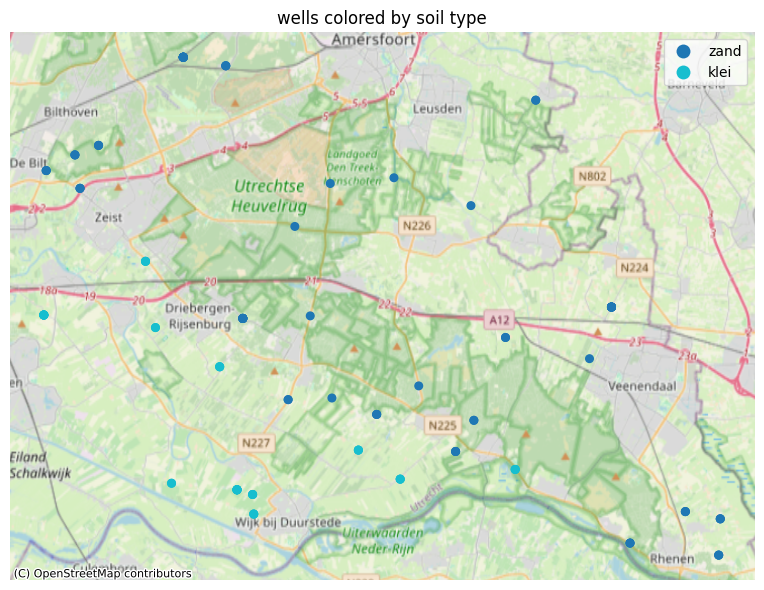

In [313]:
ax = wells.plot(
    column="soil region",
    categorical=True,
    legend=True,
    figsize=(10, 6),
    markersize=30,
    cmap="tab10"
)

contextily.add_basemap(ax, crs=wells.crs, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.title("wells colored by soil type")
plt.tight_layout()
plt.show()

## Spatial Regimes

--> We modify set of coeficients depending on the location

--> Spatial regimes (SRs) is to generalize the spatial FE approach to allow not only the constant term to vary but also any other explanatory variable

--> We want the whole model — intercept and slopes — to vary between geographic groups

In [336]:
m5 = spreg.OLS_Regimes(
    y,
    X,
    df["soil region"].tolist(),
    constant_regi="many",  # intercept per group
    regime_err_sep=False,
    name_y="log_nitrate",
    name_x=list(X_all.columns),
)

In [337]:
print(m5.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  : log_nitrate                Number of Observations:         118
Mean dependent var  :      0.9689                Number of Variables   :          28
S.D. dependent var  :      0.9850                Degrees of Freedom    :          90
R-squared           :      0.8394
Adjusted R-squared  :      0.7913
Sum squared residual:     18.2295                F-statistic           :     17.4255
Sigma-square        :       0.203                Prob(F-statistic)     :   3.205e-25
S.E. of regression  :       0.450                Log likelihood        :     -57.244
Sigma-square ML     :       0.154                Akaike info criterion :     170.487
S.E of regression ML:      0.3930                Schwarz criterion     :     248.067

----------------------------------------

CHOW test check if coefficients for each predictor is statistically different across the groups (klei vs zand)

In [339]:
res = pd.DataFrame({
    "Coeff.": m5.betas.flatten(),
    "Std. Error": m5.std_err.flatten(),
    "P-Value": [i[1] for i in m5.t_stat],
}, index=m5.name_x)

soil_types = df["soil region"].unique()

regime_tables = []
for soil in soil_types:
    matching_rows = [i for i in res.index if i.startswith(f"{soil}_")]
    regime_res = res.loc[matching_rows].rename(lambda i: i.replace(f"{soil}_", ""))
    regime_res.columns = pd.MultiIndex.from_product([[soil], regime_res.columns])
    regime_tables.append(regime_res)

comparison_table = pd.concat(regime_tables, axis=1)

comparison_table

zand                               klei  \
                           Coeff. Std. Error       P-Value    Coeff.   
CONSTANT                25.765530   5.237568  3.893622e-06 -3.354976   
population               0.001005   0.000262  2.265758e-04 -0.009521   
groundwater depth        0.244679   0.047897  1.806413e-06 -0.018844   
elevation               -0.007094   0.006292  2.625801e-01 -0.058103   
precipitation           -0.001765   0.001627  2.808346e-01 -0.000197   
temperature             -0.003656   0.001667  3.081839e-02 -0.001600   
n deposition            -0.021494   0.020017  2.857838e-01  0.071748   
organicmattercontent_1  -0.567348   0.118667  6.765871e-06  0.203516   
density_1              -12.960725   3.109319  7.040300e-05  0.848470   
acidity_1               -0.980540   0.111988  1.108956e-13  0.019289   
month                    0.014356   0.038351  7.090383e-01  0.044698   
soilunit_code_1_Y30     -0.809217   0.423362  5.913424e-02  2.092671   
soilunit_code_1_pZg21    0.772801   0.362596  3.579027e-02  0.079659   
soilunit_code_1_zEZ21    1.285352   0.171713  4.624623e-11  2.377130   

                                             
                       Std. Error   P-Value  
CONSTANT                 4.256763  0.432679  
population               0.013137  0.470471  
groundwater depth        0.066438  0.777349  
elevation                0.220567  0.792826  
precipitation            0.002218  0.929272  
temperature              0.005108  0.754834  
n deposition             0.090292  0.428924  
organicmattercontent_1   0.180353  0.262138  
density_1                1.850380  0.647671  
acidity_1                0.234155  0.934530  
month                    0.150969  0.767856  
soilunit_code_1_Y30      2.192773  0.342463  
soilunit_code_1_pZg21    0.487274  0.870509  
soilunit_code_1_zEZ21    1.220207  0.054514

--> Intercept is statistically significant (p = 0.009), suggesting a reliable baseline nitrate level when other predictors are zero

--> !! the magnitude and direction of the coefficients still differ between the two group

## Spatial dependence

--> Maybe neighbors surrounding the data point influence its value

--> We add spatial context

--> Calculate average of variables in the surrounding locations

--> NOTE: simple knn **worked better** than kernel

In [348]:
knn = KNN.from_dataframe(wells, k=4)

/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  warnings.warn(message)


In [349]:
X_all.columns

Index(['population', 'groundwater depth', 'elevation', 'precipitation',
       'temperature', 'n deposition', 'organicmattercontent_1', 'density_1',
       'acidity_1', 'month', 'soilunit_code_1_Y30', 'soilunit_code_1_pZg21',
       'soilunit_code_1_zEZ21'],
      dtype='object')

In [350]:
lagged_vars = ['groundwater depth', 'population', 'temperature', 'precipitation',
       'elevation', 'organicmattercontent_1', 'density_1', 'acidity_1', 'n deposition']

wx = X_all[lagged_vars].apply(lambda col: lag_spatial(knn, col), axis=0)

wx.columns = ["w_" + col for col in wx.columns]

In [351]:
slx_X = pd.concat([X_all, wx], axis=1)

In [352]:
y = df["log_nitrate"].values.reshape(-1, 1)

In [353]:
m6 = OLS(
    y=y,
    x=slx_X.values,
    name_y="log_nitrate",
    name_x=slx_X.columns.tolist(),
)

In [354]:
print(m6.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  : log_nitrate                Number of Observations:         118
Mean dependent var  :      0.9689                Number of Variables   :          23
S.D. dependent var  :      0.9850                Degrees of Freedom    :          95
R-squared           :      0.8376
Adjusted R-squared  :      0.8000
Sum squared residual:     18.4392                F-statistic           :     22.2680
Sigma-square        :       0.194                Prob(F-statistic)     :   2.692e-28
S.E. of regression  :       0.441                Log likelihood        :     -57.919
Sigma-square ML     :       0.156                Akaike info criterion :     161.838
S.E of regression ML:      0.3953                Schwarz criterion     :     225.563

------------------------------------------------------------

In [355]:
lagged_names = wx.columns

slx_results = pd.DataFrame({
    "Coeff.": m6.betas.flatten(),
    "Std. Error": m6.std_err.flatten(),
    "P-Value": [t[1] for t in m6.t_stat],
}, index=m6.name_x)

slx_results.loc[lagged_names].round(4)


,Coeff.,Std. Error,P-Value
w_groundwater depth,0.0333,0.0121,0.0073
w_population,0.0007,0.0005,0.1550
w_temperature,-0.0021,0.0007,0.0031
w_precipitation,0.0017,0.0007,0.0202
w_elevation,-0.0030,0.0033,0.3672
w_organicmattercontent_1,0.0480,0.0171,0.0060
w_density_1,0.6810,0.4354,0.1211
w_acidity_1,0.1516,0.0519,0.0043
w_n deposition,0.0220,0.0098,0.0267


Groundwater depth, Temperature, Precipitaion, Organic content, Acidity, N deposition significantly effect the Nitrate level at specific location

## Spacial Lag

--> How Y variable in neighborhood affects Y variable in other location

--> NOTE: Lagging nitrate from neighbours can be problematic. Nitrate is not sampled at the same time across the area

In [356]:
m8 = GM_Lag(
    y=y,
    x=X,
    w=knn,
    name_y="log_nitrate",
    name_x=list(X_all.columns),
)

In [357]:
print(m8.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : log_nitrate                Number of Observations:         118
Mean dependent var  :      0.9689                Number of Variables   :          15
S.D. dependent var  :      0.9850                Degrees of Freedom    :         103
Pseudo R-squared    :      0.7504
Spatial Pseudo R-squared:  0.6376

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         3.81313         1.66734         2.28695         0.02220
          population         0.00028         0.00024         1.17301         0.24079
   groundwater depth         0.15867      

In [2234]:
pd.DataFrame({
    "Coeff.": m8.betas.flatten(),
    "Std. Error": m8.std_err.flatten(),
    "P-Value": [z[1] for z in m8.z_stat],
}, index=m8.name_z).round(4)

,Coeff.,Std. Error,P-Value
CONSTANT,0.2243,0.5076,0.6586
avg_depth_m,0.1167,0.0787,0.1383
Population,0.0004,0.0004,0.2867
avg_temp_mean,-0.0048,0.0050,0.3356
avg_precip_sum,-0.0092,0.0113,0.4180
Elevation_m,0.0146,0.0161,0.3643
Landuse_Code_11,0.4109,0.4313,0.3407
Landuse_Code_18,-0.6794,0.5995,0.2571
Landuse_Code_26,0.0923,0.5933,0.8764
W_log_nitrate,0.1232,0.0844,0.1440


## Sum up the results

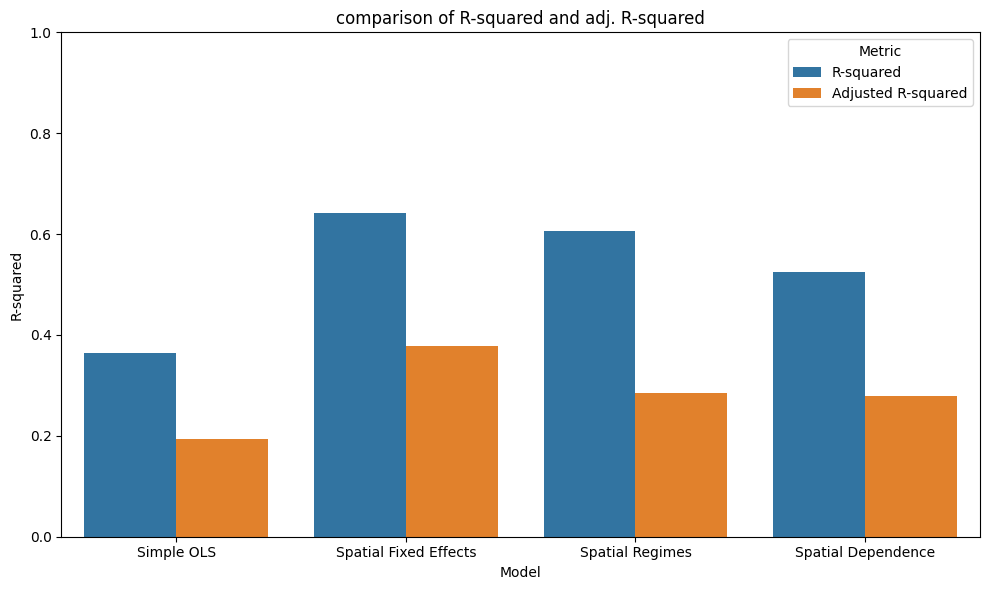

In [2237]:
data = {
    "Model": [
        "Simple OLS", "Simple OLS",
        "Spatial Fixed Effects", "Spatial Fixed Effects",
        "Spatial Regimes", "Spatial Regimes",
        "Spatial Dependence", "Spatial Dependence"
    ],
    "Metric": [
        "R-squared", "Adjusted R-squared",
        "R-squared", "Adjusted R-squared",
        "R-squared", "Adjusted R-squared",
        "R-squared", "Adjusted R-squared"
    ],
    "Value": [
        0.3635, 0.1937,
        0.641, 0.379,
        0.6053, 0.2857,
        0.5258, 0.2792
    ]
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Model", y="Value", hue="Metric")
plt.title("comparison of R-squared and adj. R-squared")
plt.ylabel("R-squared")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
